In [4]:
import re

def clean_latex_string(s):
    # Remove leading and trailing $
    s = s.strip('$')
    # Remove all backslashes
    s = s.replace('\\', '')
    # Replace 'pm' (from '\pm' or any residue) with ±
    s = re.sub(r'\s*pm\s*', ' +- ', s)
    return s

def latex_to_results(latex_str):
    tabular_match = re.search(r'\\begin{tabular}{.*?}(.*?)\\end{tabular}', latex_str, re.DOTALL)
    if not tabular_match:
        raise ValueError("No tabular block found.")
    tabular_str = tabular_match.group(1)

    results = []
    for line in tabular_str.splitlines():
        line = line.strip()
        if (
            not line
            or line.startswith("\\")
            or '&' not in line
            or 'Pair' in line
            or 'Score' in line
        ):
            continue

        # Remove trailing \\
        if line.endswith('\\\\'):
            line = line[:-2].strip()
        elif line.endswith('\\'):
            line = line[:-1].strip()

        cols = [c.strip() for c in line.split('&')]
        if len(cols) != 7:
            continue  # Skip malformed lines

        # Parse columns
        pair = clean_latex_string(cols[0])
        cointegration_score_str = cols[1]

        sci_match = re.match(
            r'^\$?([-\d\.]+)\\times\s*10\^\{(-?\d+)\}\$?$', cointegration_score_str)
        if sci_match:
            cointegration_score = float(sci_match.group(1)) * (10 ** int(sci_match.group(2)))
        else:
            try:
                cointegration_score = float(cointegration_score_str.replace('$', '').replace('%', '').strip())
            except:
                cointegration_score = cointegration_score_str

        val_mse = float(cols[2])
        test_mse = float(cols[3])
        yoy_str = clean_latex_string(cols[4])
        gt_yoy = clean_latex_string(cols[5])
        returns_score = float(cols[6])

        results.append((pair, cointegration_score, val_mse, test_mse, yoy_str, gt_yoy, returns_score))
    return results


import re

def print_averages(results):
    results_clean = [r for r in results if r[-1] != -1 and r[-1] <= 1.0]  

    val_mse_list = []
    test_mse_list = []
    yoy_mean_list = []
    yoy_stddev_list = []
    gt_yoy_list = []
    returns_score_list = []

    for r in results_clean:
        _, _, val_mse, test_mse, yoy_str, gt_yoy_str, returns_score = r

        # Validation and test MSE
        val_mse_list.append(float(val_mse))
        test_mse_list.append(float(test_mse))

        # yoy_str, e.g., '3.11% +- 0.23%'
        yoy_match = re.match(r'([-0-9.]+)% \+\- ([0-9.]+)%', yoy_str)
        if yoy_match:
            yoy_mean = float(yoy_match.group(1))
            yoy_stddev = float(yoy_match.group(2))
            yoy_mean_list.append(yoy_mean)
            yoy_stddev_list.append(yoy_stddev)
        else:
            # Handle if not in expected format (fallback to nan)
            yoy_mean_list.append(float('nan'))
            yoy_stddev_list.append(float('nan'))

        # gt_yoy, e.g., '3.31%' or '-100.00%'
        try:
            gt_yoy = float(gt_yoy_str.replace('%', ''))
        except:
            gt_yoy = float('nan')
        gt_yoy_list.append(gt_yoy)

        # returns_score
        returns_score_list.append(float(returns_score))

    import numpy as np

    def safe_mean(lst):
        arr = np.array(lst)
        return f"{np.nanmean(arr):.5f}"
    
    def safe_std(lst):
        arr = np.array(lst)
        return f"{np.nanstd(arr):.5f}"

    def safe_median(lst):
        arr = np.array(lst)
        return f"{np.nanmedian(arr):.5f}"

    print("Average (std dev) val_mse:", safe_mean(val_mse_list), "+-", safe_std(val_mse_list))
    print("Average (std dev) test_mse:", safe_mean(test_mse_list), "+-", safe_std(test_mse_list))
    print("Average yoy mean:", safe_mean(yoy_mean_list))
    print("Average yoy stddev:", safe_mean(yoy_stddev_list))
    print("Average gt_yoy:", safe_mean(gt_yoy_list))
    print("Average (std dev) returns_score:", safe_mean(returns_score_list), "+-", safe_std(returns_score_list))
    
    print("Median val_mse:", safe_median(val_mse_list))
    print("Median test_mse:", safe_median(test_mse_list))
    print("Median yoy mean:", safe_median(yoy_mean_list))
    print("Median yoy stddev:", safe_median(yoy_stddev_list))
    print("Median gt_yoy:", safe_median(gt_yoy_list))
    print("Median returns_score:", safe_median(returns_score_list))

    
    

In [5]:
kalman_str = r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 4.99826 & 13.49622 & $-52.60\% \pm 58.93\%$ & 0.16\% & 0.4732 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 11.91925 & 9.53453 & $0.24\% \pm 0.02\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 2.44704 & 5.87790 & $-0.24\% \pm 0.03\%$ & 0.57\% & 0.9919 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 7.04674 & 6.27775 & $0.39\% \pm 0.03\%$ & 0.07\% & 5.5714 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 2.45625 & 11.10707 & $2.21\% \pm 0.34\%$ & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 8.24087 & 19.50070 & $0.37\% \pm 0.02\%$ & -0.37\% & 1.0074 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 9.86063 & 11.34749 & $0.16\% \pm 0.01\%$ & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.52055 & 1.17276 & $8.48\% \pm 0.70\%$ & 40.14\% & 0.2113 \\
9. (IFGL,SOXX) & $1.82\times 10^{-3}$ & 0.71553 & 2.43627 & $5.50\% \pm 0.50\%$ & 15.96\% & 0.3446 \\
10. (IGF,PPH) & $2.29\times 10^{-3}$ & 1.53290 & 1.78350 & $1.32\% \pm 0.12\%$ & TLOE* & nan \\
11. (PFF,MBB) & $2.58\times 10^{-3}$ & 1.59049 & 3.74586 & $0.38\% \pm 0.03\%$ & 0.31\% & 1.2258 \\
12. (IGF,PKW) & $2.68\times 10^{-3}$ & 1.44136 & 4.66554 & $2.85\% \pm 0.15\%$ & TLOE* & nan \\
13. (IFGL,PHO) & $2.70\times 10^{-3}$ & 6.60638 & 5.60842 & $1.94\% \pm 0.12\%$ & 10.15\% & 0.1911 \\
14. (IFGL,QQQ) & $2.76\times 10^{-3}$ & 0.73231 & 2.51582 & $16.84\% \pm 0.61\%$ & 78.14\% & 0.2155 \\
15. (PFF,BND) & $2.78\times 10^{-3}$ & 1.84901 & 2.63888 & $0.30\% \pm 0.04\%$ & 0.14\% & 2.1429 \\
16. (PFF,SHY) & $3.04\times 10^{-3}$ & 4.00318 & 14.92111 & $0.04\% \pm 0.00\%$ & TLOE* & nan \\
17. (IFGL,ONEQ) & $3.49\times 10^{-3}$ & 1.01884 & 2.01991 & $2.51\% \pm 0.07\%$ & 14.05\% & 0.1786 \\
18. (IGF,FTCS) & $3.83\times 10^{-3}$ & 2.66918 & 11.64964 & $1.50\% \pm 0.21\%$ & TLOE* & nan \\
19. (SHY,BND) & $4.05\times 10^{-3}$ & 4.56110 & 15.86956 & $0.19\% \pm 0.04\%$ & TLOE* & nan \\
20. (IGF,PEY) & $4.10\times 10^{-3}$ & 1.65948 & 2.54887 & $0.35\% \pm 0.04\%$ & -0.34\% & 1.0069 \\
21. (IFGL,PKW) & $4.77\times 10^{-3}$ & 5.61737 & 3.14836 & $4.74\% \pm 0.24\%$ & 30.57\% & 0.1551 \\
22. (IFGL,FTCS) & $5.00\times 10^{-3}$ & 11.16817 & 7.40878 & $2.74\% \pm 0.17\%$ & TLOE* & nan \\
23. (IGF,PDP) & $5.27\times 10^{-3}$ & 1.05944 & 2.00898 & $3.10\% \pm 0.21\%$ & TLOE* & nan \\
24. (IGSB,SHV) & $5.29\times 10^{-3}$ & 41.36759 & 5.67130 & $-0.29\% \pm 0.04\%$ & 0.06\% & 0.9965 \\
25. (IFGL,USIG) & $5.35\times 10^{-3}$ & 11.67894 & 15.51695 & $0.11\% \pm 0.01\%$ & TLOE* & nan \\
26. (IFGL,PDP) & $6.21\times 10^{-3}$ & 4.25741 & 2.05212 & $4.28\% \pm 0.17\%$ & 27.37\% & 0.1564 \\
27. (IGF,BBH) & $6.33\times 10^{-3}$ & 3.47911 & 0.80322 & $0.50\% \pm 0.05\%$ & TLOE* & nan \\
28. (IFGL,SHY) & $6.79\times 10^{-3}$ & 7.54957 & 14.03887 & $0.18\% \pm 0.01\%$ & TLOE* & nan \\
29. (IFGL,PRFZ) & $7.87\times 10^{-3}$ & 6.18911 & 3.45879 & $0.92\% \pm 0.09\%$ & 6.70\% & 0.1373 \\
30. (IEF,USIG) & $7.90\times 10^{-3}$ & 1.93007 & 3.41579 & $0.16\% \pm 0.02\%$ & 1.03\% & 0.1553 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}


"""

transformer_str = r"""


\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.11676 & 0.26063 & $0.14\% \pm 0.01\%$ & 0.16\% & 0.8750 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.26413 & 0.14229 & TLOE* & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.16725 & 0.25097 & $0.49\% \pm 0.02\%$ & 0.57\% & 0.8596 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.24506 & 0.09747 & $0.01\% \pm 0.00\%$ & 0.07\% & 0.1429 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.13675 & 0.58896 & TLOE* & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.18930 & 0.20137 & $-0.62\% \pm 0.06\%$ & -0.37\% & 0.9975 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.14814 & 0.10170 & TLOE* & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 3.75906 & 38.35247 & TLOE* & 40.14\% & -1 \\
9. (IFGL,SOXX) & $1.82\times 10^{-3}$ & 1.01446 & 38.15847 & TLOE* & 15.96\% & -1 \\
10. (IGF,PPH) & $2.29\times 10^{-3}$ & 0.09983 & 1.12852 & TLOE* & TLOE* & nan \\
11. (PFF,MBB) & $2.58\times 10^{-3}$ & 0.28943 & 0.31501 & $0.36\% \pm 0.01\%$ & 0.31\% & 1.1613 \\
12. (IGF,PKW) & $2.68\times 10^{-3}$ & 0.09231 & 7.28166 & TLOE* & TLOE* & nan \\
13. (IFGL,PHO) & $2.70\times 10^{-3}$ & 3.19379 & 31.94284 & TLOE* & 10.15\% & -1 \\
14. (IFGL,QQQ) & $2.76\times 10^{-3}$ & 2.09108 & 27.76945 & TLOE* & 78.14\% & -1 \\
15. (PFF,BND) & $2.78\times 10^{-3}$ & 0.32102 & 0.14645 & $0.07\% \pm 0.01\%$ & 0.14\% & 0.5000 \\
16. (PFF,SHY) & $3.04\times 10^{-3}$ & 0.52076 & 2.41109 & TLOE* & TLOE* & nan \\
17. (IFGL,ONEQ) & $3.49\times 10^{-3}$ & 4.68723 & 36.20738 & TLOE* & 14.05\% & -1 \\
18. (IGF,FTCS) & $3.83\times 10^{-3}$ & 0.02705 & 0.53847 & TLOE* & TLOE* & nan \\
19. (SHY,BND) & $4.05\times 10^{-3}$ & 0.12682 & 0.19714 & TLOE* & TLOE* & nan \\
20. (IGF,PEY) & $4.10\times 10^{-3}$ & 0.06112 & 0.08793 & $-0.47\% \pm 0.03\%$ & -0.34\% & 0.9987 \\
21. (IFGL,PKW) & $4.77\times 10^{-3}$ & 2.69342 & 16.22046 & TLOE* & 30.57\% & -1 \\
22. (IFGL,FTCS) & $5.00\times 10^{-3}$ & 1.75347 & 18.97697 & TLOE* & TLOE* & nan \\
23. (IGF,PDP) & $5.27\times 10^{-3}$ & 0.02259 & 0.28876 & TLOE* & TLOE* & nan \\
24. (IGSB,SHV) & $5.29\times 10^{-3}$ & 32.37644 & 3.24777 & $0.00\% \pm 0.00\%$ & 0.06\% & 0.0000 \\
25. (IFGL,USIG) & $5.35\times 10^{-3}$ & 0.25509 & 0.22279 & TLOE* & TLOE* & nan \\
26. (IFGL,PDP) & $6.21\times 10^{-3}$ & 1.12327 & 16.41140 & TLOE* & 27.37\% & -1 \\
27. (IGF,BBH) & $6.33\times 10^{-3}$ & 0.08741 & 0.03647 & TLOE* & TLOE* & nan \\
28. (IFGL,SHY) & $6.79\times 10^{-3}$ & 0.77906 & 1.07961 & TLOE* & TLOE* & nan \\
29. (IFGL,PRFZ) & $7.87\times 10^{-3}$ & 5.70549 & 14.33761 & $4.03\% \pm 0.04\%$ & 6.70\% & 0.6015 \\
30. (IEF,USIG) & $7.90\times 10^{-3}$ & 0.15058 & 1.50452 & $0.76\% \pm 0.03\%$ & 1.03\% & 0.7379 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}


"""

time_moe_str = r"""


\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.10627 & 0.09116 & $0.11\% \pm 0.03\%$ & 0.16\% & 0.6875 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.19378 & 0.10622 & $-98.80\% \pm 29.88\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.09751 & 0.08337 & $-29.38\% \pm 50.28\%$ & 0.57\% & 0.7022 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.07641 & 0.07921 & $0.09\% \pm 0.01\%$ & 0.07\% & 1.2857 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.05064 & 0.13567 & TLOE* & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.09513 & 0.18667 & $-0.54\% \pm 0.15\%$ & -0.37\% & 0.9983 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.15534 & 0.10321 & TLOE* & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.01982 & 0.08246 & $48.22\% \pm 13.61\%$ & 40.14\% & 1.2013 \\
9. (IFGL,SOXX) & $1.82\times 10^{-3}$ & 0.02879 & 0.13849 & $26.76\% \pm 9.00\%$ & 15.96\% & 1.6767 \\
10. (IGF,PPH) & $2.29\times 10^{-3}$ & 0.03007 & 0.03391 & TLOE* & TLOE* & nan \\
11. (PFF,MBB) & $2.58\times 10^{-3}$ & 0.15600 & 0.09352 & $0.30\% \pm 0.10\%$ & 0.31\% & 0.9677 \\
12. (IGF,PKW) & $2.68\times 10^{-3}$ & 0.01972 & 0.05615 & TLOE* & TLOE* & nan \\
13. (IFGL,PHO) & $2.70\times 10^{-3}$ & 0.03779 & 0.06508 & $12.77\% \pm 2.83\%$ & 10.15\% & 1.2581 \\
14. (IFGL,QQQ) & $2.76\times 10^{-3}$ & 0.01036 & 0.03726 & TLOE* & 78.14\% & -1 \\
15. (PFF,BND) & $2.78\times 10^{-3}$ & 0.14267 & 0.09753 & $0.09\% \pm 0.03\%$ & 0.14\% & 0.6429 \\
16. (PFF,SHY) & $3.04\times 10^{-3}$ & 0.09618 & 0.10584 & $-92.09\% \pm 50.01\%$ & TLOE* & nan \\
17. (IFGL,ONEQ) & $3.49\times 10^{-3}$ & 0.01211 & 0.02849 & $13.13\% \pm 3.11\%$ & 14.05\% & 0.9345 \\
18. (IGF,FTCS) & $3.83\times 10^{-3}$ & 0.02004 & 0.10683 & TLOE* & TLOE* & nan \\
19. (SHY,BND) & $4.05\times 10^{-3}$ & 0.04686 & 0.07972 & $-76.24\% \pm 61.62\%$ & TLOE* & nan \\
20. (IGF,PEY) & $4.10\times 10^{-3}$ & 0.05286 & 0.10100 & $-15.61\% \pm 37.53\%$ & -0.34\% & 0.8468 \\
21. (IFGL,PKW) & $4.77\times 10^{-3}$ & 0.02679 & 0.01705 & $24.71\% \pm 5.04\%$ & 30.57\% & 0.8083 \\
22. (IFGL,FTCS) & $5.00\times 10^{-3}$ & 0.03208 & 0.03231 & TLOE* & TLOE* & nan \\
23. (IGF,PDP) & $5.27\times 10^{-3}$ & 0.02645 & 0.08855 & $-73.41\% \pm 66.20\%$ & TLOE* & nan \\
24. (IGSB,SHV) & $5.29\times 10^{-3}$ & 0.10288 & 0.02525 & $0.15\% \pm 0.06\%$ & 0.06\% & 2.5000 \\
25. (IFGL,USIG) & $5.35\times 10^{-3}$ & 0.14618 & 0.09754 & TLOE* & TLOE* & nan \\
26. (IFGL,PDP) & $6.21\times 10^{-3}$ & 0.03299 & 0.02862 & $25.74\% \pm 4.09\%$ & 27.37\% & 0.9404 \\
27. (IGF,BBH) & $6.33\times 10^{-3}$ & 0.11199 & 0.05304 & TLOE* & TLOE* & nan \\
28. (IFGL,SHY) & $6.79\times 10^{-3}$ & 0.07119 & 0.08850 & TLOE* & TLOE* & nan \\
29. (IFGL,PRFZ) & $7.87\times 10^{-3}$ & 0.06617 & 0.04497 & $7.14\% \pm 1.01\%$ & 6.70\% & 1.0657 \\
30. (IEF,USIG) & $7.90\times 10^{-3}$ & 0.03858 & 0.05688 & $0.90\% \pm 0.18\%$ & 1.03\% & 0.8738 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}



"""

kalman_results = latex_to_results(kalman_str)
transformer_results = latex_to_results(transformer_str)
time_moe_results = latex_to_results(time_moe_str)

In [6]:
# 2023 

kalman_str = r"""
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $2.82\times 10^{-4}$ & 3.34988 & 4.81093 & $0.03\% \pm 0.11\%$ & -0.09\% & 1.00 \\
2. (IFGL,EMB) & $7.70\times 10^{-4}$ & 1.17095 & 2.85317 & $0.01\% \pm 0.08\%$ & 0.95\% & 0.99 \\
3. (IGF,DVY) & $1.17\times 10^{-3}$ & 14.83494 & 3.46557 & $-96.55\% \pm 36.14\%$ & TLOE* & -1 \\
4. (IGIB,IEI) & $1.25\times 10^{-3}$ & 0.63734 & 4.93432 & $0.27\% \pm 0.04\%$ & 0.73\% & 1.00 \\
5. (DVY,PEY) & $1.57\times 10^{-3}$ & 1.05971 & 0.38215 & $-0.24\% \pm 0.04\%$ & 0.22\% & 1.00 \\
6. (USIG,IEI) & $1.67\times 10^{-3}$ & 0.56571 & 7.23909 & $0.29\% \pm 0.03\%$ & 0.90\% & 0.99 \\
7. (IFGL,BND) & $1.93\times 10^{-3}$ & 1.15736 & 10.52210 & $0.16\% \pm 0.01\%$ & 0.37\% & 1.00 \\
8. (IFGL,SMH) & $2.58\times 10^{-3}$ & 1.44797 & 0.78502 & $4.28\% \pm 0.39\%$ & 24.29\% & 0.84 \\
9. (IFGL,MBB) & $2.63\times 10^{-3}$ & 0.86877 & 11.98068 & $0.22\% \pm 0.02\%$ & -0.40\% & 1.01 \\
10. (IFGL,SOXX) & $2.70\times 10^{-3}$ & 1.32332 & 1.00932 & $3.71\% \pm 0.48\%$ & TLOE* & -1 \\
11. (SHV,TLT) & $2.78\times 10^{-3}$ & 0.07210 & 0.56178 & $0.75\% \pm 0.04\%$ & TLOE* & -1 \\
12. (IGF,PEY) & $2.84\times 10^{-3}$ & 11.04191 & 1.97893 & $-0.10\% \pm 0.02\%$ & 0.21\% & 1.00 \\
13. (PFF,BND) & $3.46\times 10^{-3}$ & 1.58662 & 1.95755 & $0.34\% \pm 0.09\%$ & 0.57\% & 1.00 \\
14. (IGF,BBH) & $3.53\times 10^{-3}$ & 0.29239 & 3.66527 & $-0.20\% \pm 0.08\%$ & TLOE* & -1 \\
15. (IFGL,PHO) & $3.58\times 10^{-3}$ & 3.29683 & 6.36110 & $0.77\% \pm 0.02\%$ & 6.45\% & 0.95 \\
16. (IFGL,QQQ) & $3.94\times 10^{-3}$ & 2.79705 & 0.94635 & $14.37\% \pm 1.07\%$ & 88.38\% & 0.61 \\
17. (IFGL,USIG) & $4.28\times 10^{-3}$ & 2.09187 & 13.03757 & $0.09\% \pm 0.01\%$ & 0.54\% & 1.00 \\
18. (PFF,MBB) & $4.29\times 10^{-3}$ & 1.24272 & 1.58025 & $0.54\% \pm 0.15\%$ & 0.33\% & 1.00 \\
19. (IFGL,ONEQ) & $4.77\times 10^{-3}$ & 2.85792 & 1.30785 & $1.35\% \pm 0.13\%$ & 10.43\% & 0.92 \\
20. (IGSB,BND) & $4.80\times 10^{-3}$ & 1.55709 & 9.58753 & $1.16\% \pm 0.21\%$ & 1.54\% & 1.00 \\
21. (IGF,PKW) & $4.93\times 10^{-3}$ & 0.98355 & 1.54716 & $0.83\% \pm 0.06\%$ & TLOE* & -1 \\
22. (IFGL,QCLN) & $5.03\times 10^{-3}$ & 1.01548 & 1.00995 & $-0.20\% \pm 0.02\%$ & TLOE* & -1 \\
23. (IFGL,FTCS) & $5.45\times 10^{-3}$ & 6.42528 & 10.78998 & $1.15\% \pm 0.15\%$ & 9.13\% & 0.93 \\
24. (PFF,SHY) & $5.49\times 10^{-3}$ & 0.76163 & 4.45999 & $0.40\% \pm 0.02\%$ & 1.04\% & 0.99 \\
25. (IFGL,PKW) & $5.74\times 10^{-3}$ & 7.67365 & 5.49794 & $1.65\% \pm 0.05\%$ & TLOE* & -1 \\
26. (IGSB,SHV) & $5.97\times 10^{-3}$ & 1.34117 & 26.26786 & $0.68\% \pm 0.17\%$ & 0.14\% & 1.01 \\
27. (SHY,BND) & $6.16\times 10^{-3}$ & 0.50222 & 4.91233 & $1.10\% \pm 0.24\%$ & 1.72\% & 0.99 \\
28. (IGF,FTCS) & $6.19\times 10^{-3}$ & 1.30721 & 2.76866 & $0.55\% \pm 0.06\%$ & TLOE* & -1 \\
29. (IGF,PPH) & $6.29\times 10^{-3}$ & 3.81793 & 1.99878 & $0.36\% \pm 0.02\%$ & 2.93\% & 0.98 \\
30. (IFGL,SHY) & $7.01\times 10^{-3}$ & 0.74680 & 8.01002 & $0.96\% \pm 0.08\%$ & 1.99\% & 0.99 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}

"""

transformer_str = r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $2.82\times 10^{-4}$ & 0.6357564 & 0.6874711 & $0.15\% \pm 0.01\%$ & -0.09\% & 1.00 \\
2. (IFGL,EMB) & $7.70\times 10^{-4}$ & 0.20647542 & 1.3481009 & $0.19\% \pm 0.03\%$ & 0.95\% & 0.99 \\
3. (IGF,DVY) & $1.17\times 10^{-3}$ & 3.0436642 & 0.2773689 & TLOE* & TLOE* & -1 \\
4. (IGIB,IEI) & $1.25\times 10^{-3}$ & 0.094758466 & 0.3638136 & $0.78\% \pm 0.05\%$ & 0.73\% & 1.00 \\
5. (DVY,PEY) & $1.57\times 10^{-3}$ & 0.13883077 & 0.057962157 & $0.24\% \pm 0.01\%$ & 0.22\% & 1.00 \\
6. (USIG,IEI) & $1.67\times 10^{-3}$ & 0.100599535 & 0.30912006 & $0.59\% \pm 0.02\%$ & 0.90\% & 1.00 \\
7. (IFGL,BND) & $1.93\times 10^{-3}$ & 0.055076033 & 0.28797114 & $-0.18\% \pm 0.11\%$ & 0.37\% & 0.99 \\
8. (IFGL,SMH) & $2.58\times 10^{-3}$ & 2.239128 & 3.146959 & $17.18\% \pm 0.56\%$ & 24.29\% & 0.94 \\
9. (IFGL,MBB) & $2.63\times 10^{-3}$ & 0.45405787 & 7.6492076 & $0.09\% \pm 0.03\%$ & -0.40\% & 1.00 \\
10. (IFGL,SOXX) & $2.70\times 10^{-3}$ & 3.6629803 & 3.186468 & $20.75\% \pm 0.31\%$ & TLOE* & -1 \\
11. (SHV,TLT) & $2.78\times 10^{-3}$ & 0.016398733 & 0.072651416 & TLOE* & TLOE* & -1 \\
12. (IGF,PEY) & $2.84\times 10^{-3}$ & 0.64646006 & 0.11650448 & $0.28\% \pm 0.01\%$ & 0.21\% & 1.00 \\
13. (PFF,BND) & $3.46\times 10^{-3}$ & 0.20852436 & 0.123664655 & $0.77\% \pm 0.05\%$ & 0.57\% & 1.00 \\
14. (IGF,BBH) & $3.53\times 10^{-3}$ & 0.05271519 & 0.105158806 & TLOE* & TLOE* & -1 \\
15. (IFGL,PHO) & $3.58\times 10^{-3}$ & 0.16062228 & 4.42423 & TLOE* & 6.45\% & 0.00 \\
16. (IFGL,QQQ) & $3.94\times 10^{-3}$ & 0.23663928 & 1.0293903 & $105.24\% \pm 2.13\%$ & 88.38\% & 1.09 \\
17. (IFGL,USIG) & $4.28\times 10^{-3}$ & 0.043551404 & 0.22294645 & $0.36\% \pm 0.13\%$ & 0.54\% & 1.00 \\
18. (PFF,MBB) & $4.29\times 10^{-3}$ & 0.20999373 & 0.1384038 & $0.37\% \pm 0.02\%$ & 0.33\% & 1.00 \\
19. (IFGL,ONEQ) & $4.77\times 10^{-3}$ & 0.19775832 & 0.6438796 & $12.60\% \pm 0.16\%$ & 10.43\% & 1.02 \\
20. (IGSB,BND) & $4.80\times 10^{-3}$ & 0.346146 & 4.944444 & $0.57\% \pm 0.09\%$ & 1.54\% & 0.99 \\
21. (IGF,PKW) & $4.93\times 10^{-3}$ & 0.055040438 & 0.10897328 & TLOE* & TLOE* & -1 \\
22. (IFGL,QCLN) & $5.03\times 10^{-3}$ & 0.17480528 & 0.044853784 & TLOE* & TLOE* & -1 \\
23. (IFGL,FTCS) & $5.45\times 10^{-3}$ & 0.7023212 & 6.9438877 & $12.58\% \pm 0.14\%$ & 9.13\% & 1.03 \\
24. (PFF,SHY) & $5.49\times 10^{-3}$ & 0.17921631 & 0.7950051 & $2.21\% \pm 0.06\%$ & 1.04\% & 1.01 \\
25. (IFGL,PKW) & $5.74\times 10^{-3}$ & 0.9213854 & 7.8331375 & TLOE* & TLOE* & -1 \\
26. (IGSB,SHV) & $5.97\times 10^{-3}$ & 0.08203684 & 0.5717601 & $0.13\% \pm 0.09\%$ & 0.14\% & 1.00 \\
27. (SHY,BND) & $6.16\times 10^{-3}$ & 0.02087853 & 0.11335704 & $2.09\% \pm 0.10\%$ & 1.72\% & 1.00 \\
28. (IGF,FTCS) & $6.19\times 10^{-3}$ & 0.07607144 & 0.03148373 & TLOE* & TLOE* & -1 \\
29. (IGF,PPH) & $6.29\times 10^{-3}$ & 0.0872204 & 0.093840584 & $4.38\% \pm 0.18\%$ & 2.93\% & 1.01 \\
30. (IFGL,SHY) & $7.01\times 10^{-3}$ & 0.16995217 & 2.381965 & $0.62\% \pm 0.00\%$ & 1.99\% & 0.99 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}

"""

time_moe_str = r"""

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $2.82\times 10^{-4}$ & 0.05697 & 0.10831 & $-0.09\% \pm 0.02\%$ & -0.09\% & 1.0000 \\
2. (IFGL,EMB) & $7.70\times 10^{-4}$ & 0.04260 & 0.09643 & $0.93\% \pm 0.19\%$ & 0.95\% & 0.9789 \\
3. (IGF,DVY) & $1.17\times 10^{-3}$ & 0.15228 & 0.04975 & TLOE* & TLOE* & nan \\
4. (IGIB,IEI) & $1.25\times 10^{-3}$ & 0.03259 & 0.07647 & $0.68\% \pm 0.16\%$ & 0.73\% & 0.9315 \\
5. (DVY,PEY) & $1.57\times 10^{-3}$ & 0.12517 & 0.05846 & $0.16\% \pm 0.02\%$ & 0.22\% & 0.7273 \\
6. (USIG,IEI) & $1.67\times 10^{-3}$ & 0.03536 & 0.09429 & $0.50\% \pm 0.18\%$ & 0.90\% & 0.5556 \\
7. (IFGL,BND) & $1.93\times 10^{-3}$ & 0.04039 & 0.15281 & $0.72\% \pm 0.42\%$ & 0.37\% & 1.9459 \\
8. (IFGL,SMH) & $2.58\times 10^{-3}$ & 0.21572 & 0.02283 & $25.97\% \pm 2.81\%$ & 24.29\% & 1.0692 \\
9. (IFGL,MBB) & $2.63\times 10^{-3}$ & 0.03722 & 0.19085 & $0.69\% \pm 0.42\%$ & -0.40\% & 1.0109 \\
10. (IFGL,SOXX) & $2.70\times 10^{-3}$ & 0.19012 & 0.03217 & $21.74\% \pm 2.38\%$ & TLOE* & nan \\
11. (SHV,TLT) & $2.78\times 10^{-3}$ & 0.01964 & 0.03474 & TLOE* & TLOE* & nan \\
12. (IGF,PEY) & $2.84\times 10^{-3}$ & 0.13826 & 0.05298 & $0.08\% \pm 0.05\%$ & 0.21\% & 0.3810 \\
13. (PFF,BND) & $3.46\times 10^{-3}$ & 0.16726 & 0.14074 & $0.24\% \pm 0.08\%$ & 0.57\% & 0.4211 \\
14. (IGF,BBH) & $3.53\times 10^{-3}$ & 0.06334 & 0.11445 & $4.46\% \pm 0.72\%$ & TLOE* & nan \\
15. (IFGL,PHO) & $3.58\times 10^{-3}$ & 0.03561 & 0.04174 & $-9.03\% \pm 39.48\%$ & 6.45\% & 0.8546 \\
16. (IFGL,QQQ) & $3.94\times 10^{-3}$ & 0.18733 & 0.01107 & $98.30\% \pm 11.41\%$ & 88.38\% & 1.1122 \\
17. (IFGL,USIG) & $4.28\times 10^{-3}$ & 0.04454 & 0.14523 & $0.73\% \pm 0.17\%$ & 0.54\% & 1.3519 \\
18. (PFF,MBB) & $4.29\times 10^{-3}$ & 0.15954 & 0.15189 & $0.02\% \pm 0.10\%$ & 0.33\% & 0.0606 \\
19. (IFGL,ONEQ) & $4.77\times 10^{-3}$ & 0.15851 & 0.01328 & $11.40\% \pm 1.43\%$ & 10.43\% & 1.0930 \\
20. (IGSB,BND) & $4.80\times 10^{-3}$ & 0.01997 & 0.03768 & $1.61\% \pm 0.23\%$ & 1.54\% & 1.0455 \\
21. (IGF,PKW) & $4.93\times 10^{-3}$ & 0.05421 & 0.02086 & TLOE* & TLOE* & nan \\
22. (IFGL,QCLN) & $5.03\times 10^{-3}$ & 0.08239 & 0.03331 & TLOE* & TLOE* & nan \\
23. (IFGL,FTCS) & $5.45\times 10^{-3}$ & 0.03149 & 0.03265 & $10.97\% \pm 2.00\%$ & 9.13\% & 1.2015 \\
24. (PFF,SHY) & $5.49\times 10^{-3}$ & 0.04871 & 0.09344 & $0.28\% \pm 0.28\%$ & 1.04\% & 0.2692 \\
25. (IFGL,PKW) & $5.74\times 10^{-3}$ & 0.05332 & 0.02917 & TLOE* & TLOE* & nan \\
26. (IGSB,SHV) & $5.97\times 10^{-3}$ & 0.02532 & 0.10306 & $0.52\% \pm 0.26\%$ & 0.14\% & 3.7143 \\
27. (SHY,BND) & $6.16\times 10^{-3}$ & 0.02327 & 0.04690 & $2.14\% \pm 0.83\%$ & 1.72\% & 1.2442 \\
28. (IGF,FTCS) & $6.19\times 10^{-3}$ & 0.04822 & 0.01993 & $-91.51\% \pm 52.79\%$ & TLOE* & nan \\
29. (IGF,PPH) & $6.29\times 10^{-3}$ & 0.10121 & 0.03016 & $3.48\% \pm 0.21\%$ & 2.93\% & 1.1877 \\
30. (IFGL,SHY) & $7.01\times 10^{-3}$ & 0.02293 & 0.06962 & $2.08\% \pm 0.76\%$ & 1.99\% & 1.0452 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}



"""

kalman_results_2023 = latex_to_results(kalman_str)
transformer_results_2023 = latex_to_results(transformer_str)
time_moe_results_2023 = latex_to_results(time_moe_str)

In [16]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')


('2. (IFGL,MBB)', 0.00044500000000000003, 11.91925, 9.53453, '0.24% +- 0.02%', 'TLOE*', nan)
('5. (IGF,DVY)', 0.00084, 2.45625, 11.10707, '2.21% +- 0.34%', 'TLOE*', nan)
('7. (IFGL,BND)', 0.0012, 9.86063, 11.34749, '0.16% +- 0.01%', 'TLOE*', nan)
('10. (IGF,PPH)', 0.00229, 1.5329, 1.7835, '1.32% +- 0.12%', 'TLOE*', nan)
('12. (IGF,PKW)', 0.00268, 1.44136, 4.66554, '2.85% +- 0.15%', 'TLOE*', nan)
('16. (PFF,SHY)', 0.00304, 4.00318, 14.92111, '0.04% +- 0.00%', 'TLOE*', nan)
('18. (IGF,FTCS)', 0.00383, 2.66918, 11.64964, '1.50% +- 0.21%', 'TLOE*', nan)
('19. (SHY,BND)', 0.00405, 4.5611, 15.86956, '0.19% +- 0.04%', 'TLOE*', nan)
('22. (IFGL,FTCS)', 0.005, 11.16817, 7.40878, '2.74% +- 0.17%', 'TLOE*', nan)
('23. (IGF,PDP)', 0.0052699999999999995, 1.05944, 2.00898, '3.10% +- 0.21%', 'TLOE*', nan)
('25. (IFGL,USIG)', 0.00535, 11.67894, 15.51695, '0.11% +- 0.01%', 'TLOE*', nan)
('27. (IGF,BBH)', 0.0063300000000000006, 3.47911, 0.80322, '0.50% +- 0.05%', 'TLOE*', nan)
('28. (IFGL,SHY)', 0.00679

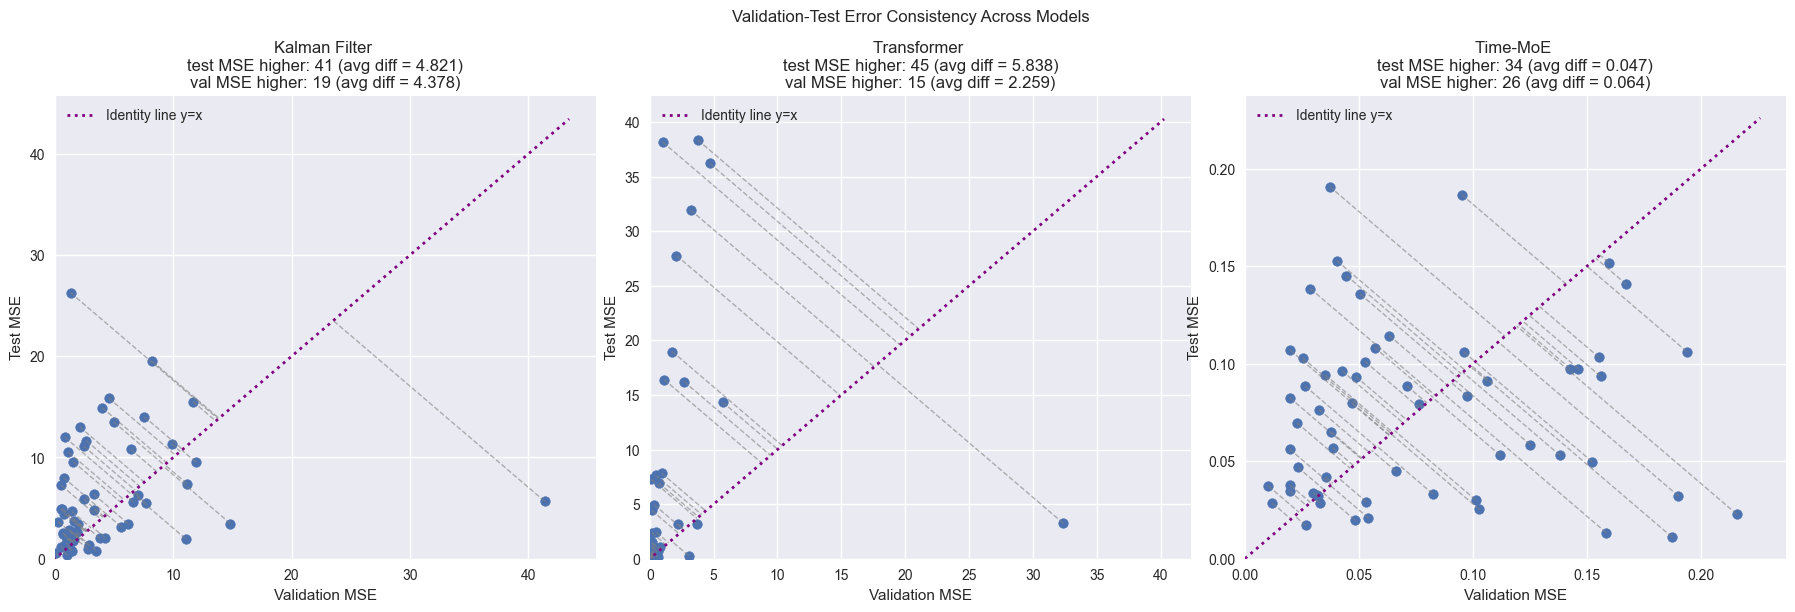

In [59]:
# plot 1: Comparison of validation and test MSE over all three models, over 2023 and 2024

def plot_(results, results_2023, idx, model_name):
    val_mse_list = []
    test_mse_list = []
    # [0] Pair & 
    # [1] Cointegration Score & 
    # [2]val MSE & 
    # [3] test MSE &
    # [4] YoY Returns (std) &
    # [5] \makecell{Theoretical Return\\Under Perfect\\Information} & 
    # [6] Return Score \\
    for r in results:
        val_mse_list.append(r[2])
        test_mse_list.append(r[3])
    for r in results_2023:
        val_mse_list.append(r[2])
        test_mse_list.append(r[3])
        
    for idxxx, r in enumerate(results + results_2023):
        if "TLOE*" in r[5]:
            print(r)

    axs[idx].scatter(val_mse_list, test_mse_list)
    
    for x, y in zip(val_mse_list, test_mse_list):
        m = (x + y) / 2
        axs[idx].plot([x, m], [y, m], color='grey', linestyle='dashed', linewidth=1, alpha=0.6)
    
    
    lims = [
        np.min([axs[idx].get_xlim(), axs[idx].get_ylim()]), 
        np.max([axs[idx].get_xlim(), axs[idx].get_ylim()]), 
    ]
    axs[idx].plot(lims, lims, 'purple', linestyle='dotted', linewidth=2, label="Identity line y=x")
    axs[idx].set_ylabel("Test MSE")
    axs[idx].set_xlabel("Validation MSE")
    axs[idx].set_xlim(left=0)
    axs[idx].set_ylim(bottom=0)
    axs[idx].legend()
    
    val_mse_arr = np.array(val_mse_list)
    test_mse_arr = np.array(test_mse_list)

    right_of_line = np.sum(val_mse_arr > test_mse_arr)
    left_of_line = np.sum(val_mse_arr < test_mse_arr)
    on_the_line = np.sum(val_mse_arr == test_mse_arr)  
    
    # Compute signed distances
    left_mask = test_mse_arr > val_mse_arr
    right_mask = val_mse_arr > test_mse_arr

    # Left of the line (test > val)
    avg_left_dist = np.mean(test_mse_arr[left_mask] - val_mse_arr[left_mask]) if np.any(left_mask) else 0

    # Right of the line (val > test)
    avg_right_dist = np.mean(val_mse_arr[right_mask] - test_mse_arr[right_mask]) if np.any(right_mask) else 0

    
    axs[idx].set_title(f"{model_name} \ntest MSE higher: {left_of_line} (avg diff = {avg_left_dist:.3f})\nval MSE higher: {right_of_line} (avg diff = {avg_right_dist:.3f})")
    
    
fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
fig.suptitle("Validation-Test Error Consistency Across Models")
fig.tight_layout(rect=[0, 0, 1, 0.92])

plot_(kalman_results, kalman_results_2023, 0, "Kalman Filter")
plot_(transformer_results, transformer_results_2023, 1, "Transformer")
plot_(time_moe_results, time_moe_results_2023, 2, "Time-MoE")

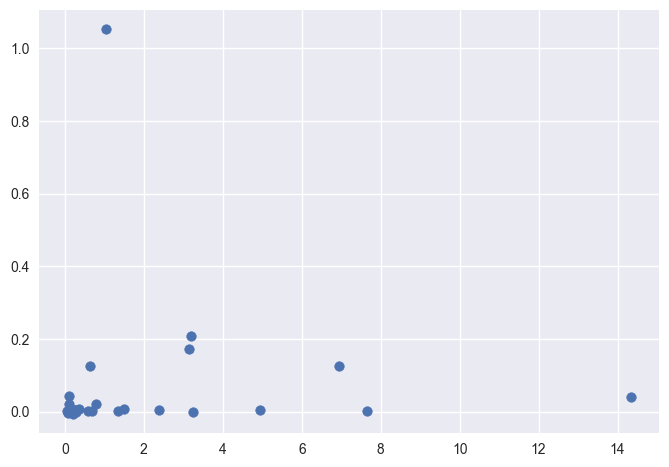

In [49]:
# plot 3: Predictive Accuracy vs. Economic Peformance Comparison Between Models
test_mse_list = []
yoy_return_list = []
results = transformer_results
results_2023 = transformer_results_2023

# [0] Pair & 
# [1] Cointegration Score & 
# [2]val MSE & 
# [3] test MSE &
# [4] YoY Returns (std) &
# [5] \makecell{Theoretical Return\\Under Perfect\\Information} & 
# [6] Return Score \\

for r in results:
    yoy_return_str = r[4]
    if yoy_return_str == "TLOE*":
        continue
        # mean_yoy_return = -1
    else:
        mean_yoy_return = float(yoy_return_str.split("%")[0]) / 100
    yoy_return_list.append(mean_yoy_return)
    test_mse_list.append(r[3])
for r in results_2023:
    yoy_return_str = r[4]
    if yoy_return_str == "TLOE*":
        continue
        # mean_yoy_return = -1
    else:
        mean_yoy_return = float(yoy_return_str.split("%")[0]) / 100
    yoy_return_list.append(mean_yoy_return)
    test_mse_list.append(r[3])

plt.scatter(test_mse_list, yoy_return_list)

In [ ]:
# plot 2: Empirical example of low test MSE and high validation MSE due to similarity in patterns between train and test timeseries

In [ ]:
# plot 4 (other notebook, need timeseries): Progression of equity for randomly chosen pair of etfs (tickera, tickerb)overtimeperiodof (2008 − 2024)